# Pip install these packages in Terminal
pip install -U gensim

pip install spacy

pip install pyLDAvis

## Import all the packages and Dataset

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
import spacy

[nltk_data] Downloading package stopwords to /Users/priya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Regex
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
#Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


# Data Preprocessing

In [5]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [6]:
#Remove HTML Tags
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [7]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

In [8]:
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = list(cont.expand_texts([text], precise=True))[0]
    return text

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[2])

['from', 'thomas', 'willis', 'subject', 'pb', 'questions', 'organization', 'purdue', 'university', 'engineering', 'computer', 'network', 'distribution', 'usa', 'lines', 'well', 'folks', 'my', 'mac', 'plus', 'finally', 'gave', 'up', 'the', 'ghost', 'this', 'weekend', 'after', 'starting', 'life', 'as', 'way', 'back', 'in', 'sooo', 'im', 'in', 'the', 'market', 'for', 'new', 'machine', 'bit', 'sooner', 'than', 'intended', 'to', 'be', 'im', 'looking', 'into', 'picking', 'up', 'powerbook', 'or', 'maybe', 'and', 'have', 'bunch', 'of', 'questions', 'that', 'hopefully', 'somebody', 'can', 'answer', 'does', 'anybody', 'know', 'any', 'dirt', 'on', 'when', 'the', 'next', 'round', 'of', 'powerbook', 'introductions', 'are', 'expected', 'id', 'heard', 'the', 'was', 'supposed', 'to', 'make', 'an', 'appearence', 'this', 'summer', 'but', 'havent', 'heard', 'anymore', 'on', 'it', 'and', 'since', 'dont', 'have', 'access', 'to', 'macleak', 'was', 'wondering', 'if', 'anybody', 'out', 'there', 'had', 'more',

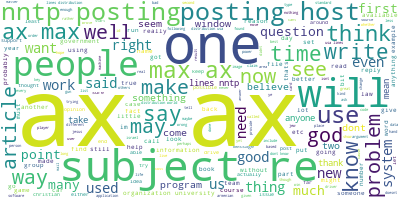

In [10]:
from wordcloud import WordCloud 
sample_list = []
for sublist in data_words:
    for item in sublist:
        sample_list.append(item)
        
list_string = ','.join((sample_list))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue')
wordcloud.generate(list_string)
wordcloud.to_image()

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram [same Output can be received by just using the above code as well]
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[2]]])

['from', 'thomas', 'willis', 'subject', 'pb', 'questions', 'organization', 'purdue_university_engineering', 'computer', 'network', 'distribution_usa', 'lines', 'well', 'folks', 'my', 'mac', 'plus', 'finally', 'gave', 'up', 'the', 'ghost', 'this', 'weekend', 'after', 'starting', 'life', 'as', 'way', 'back', 'in', 'sooo', 'im', 'in', 'the', 'market', 'for', 'new', 'machine', 'bit', 'sooner', 'than', 'intended', 'to', 'be', 'im', 'looking', 'into', 'picking', 'up', 'powerbook', 'or', 'maybe', 'and', 'have', 'bunch', 'of', 'questions', 'that', 'hopefully', 'somebody', 'can', 'answer', 'does', 'anybody', 'know', 'any', 'dirt', 'on', 'when', 'the', 'next', 'round', 'of', 'powerbook', 'introductions', 'are', 'expected', 'id', 'heard', 'the', 'was', 'supposed', 'to', 'make', 'an', 'appearence', 'this', 'summer', 'but', 'havent', 'heard', 'anymore', 'on', 'it', 'and', 'since', 'dont', 'have', 'access', 'to', 'macleak', 'was', 'wondering', 'if', 'anybody', 'out', 'there', 'had', 'more', 'info', 

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[2])

['question', 'engineering', 'computer', 'network', 'distribution_usa', 'line', 'well', 'finally', 'give', 'ghost', 'weekend', 'start', 'life', 'way', 'back', 'sooo', 'be', 'market', 'new', 'machine', 'bit', 'soon', 'intend', 'be', 'look', 'pick', 'maybe', 'bunch', 'question', 'hopefully', 'answer', 'know', 'dirt', 'next', 'introduction', 'expect', 'd', 'hear', 'suppose', 'make', 'appearence', 'summer', 'hear', 'anymore', 'access', 'macleak', 'wonder', 'info', 'hear', 'rumor', 'price', 'drop', 'line', 'one', 'go', 'recently', 's', 'impression', 'display', 'could', 'probably', 'swing', 'get', 'disk', 'rather', 'really', 'feel', 'much', 'well', 'display', 'look', 'great', 'store', 'really', 'good', 'could', 'solicit', 'opinion', 'people', 'day', 'worth', 'take', 'disk', 'size', 'money', 'hit', 'active', 'display', 'realize', 'real', 'subjective', 'question', 'have', 'play', 'machine', 'computer', 'store', 'breifly', 'figure', 'opinion', 'actually', 'use', 'machine', 'daily', 'may', 'prove

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[2])

[(5, 3), (6, 1), (14, 2), (15, 1), (18, 2), (19, 2), (21, 1), (28, 2), (35, 1), (38, 1), (43, 1), (55, 1), (62, 1), (76, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 2), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 2), (99, 3), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1), (116, 3), (117, 1), (118, 1), (119, 1), (120, 1), (121, 1), (122, 1), (123, 1), (124, 1), (125, 1), (126, 1), (127, 3), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 1), (134, 1), (135, 1), (136, 1), (137, 1), (138, 1), (139, 2), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 3), (150, 1), (151, 1), (152, 1), (153, 1), (154, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 2), (163, 1), (164, 1), (165, 1), (166, 1), (167, 1), (168, 1), (169,

# Run the LDA Model

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_topics=2, num_words=10))
doc_lda = lda_model[corpus]

[(0,
  '0.011*"line" + 0.010*"write" + 0.009*"would" + 0.006*"say" + 0.006*"know" + '
  '0.006*"article" + 0.006*"people" + 0.006*"make" + 0.005*"be" + '
  '0.005*"think"'),
 (1,
  '0.371*"ax" + 0.022*"team" + 0.017*"game" + 0.013*"player" + 0.009*"play" + '
  '0.008*"hockey" + 0.008*"season" + 0.007*"score" + 0.005*"win" + '
  '0.005*"playoff"')]


# Get the Coherence Score to check how good the Model is:

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.858967564217417

Coherence Score:  0.6384698542264106


# Visulaizations

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.262906  0.0       1        1  93.612831
1     -0.262906  0.0       2        1   6.387170, topic_info=        Term          Freq         Total Category  logprob  loglift
3718      ax  27707.000000  27707.000000  Default  30.0000  30.0000
709     team   1861.000000   1861.000000  Default  29.0000  29.0000
1693    game   1592.000000   1592.000000  Default  28.0000  28.0000
143     play   1221.000000   1221.000000  Default  27.0000  27.0000
755   player   1010.000000   1010.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1525    goal    234.098816    495.119568   Topic2  -5.7644   2.0018
1101   trade    123.978157    385.825073   Topic2  -6.4000   1.6156
425     lose    141.453400    844.721558   Topic2  -6.2682   0.9638
119      hit    117.007050    536.203613   Topic2  -6.4579   1.2286
2229    star    102.371376    280.168427   Topic2  -6.5915   1.7441

[119 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9103      1  0.014238   alomar
9103      2  0.996642   alomar
407       1  0.999942     also
407       2  0.000233     also
177       1  0.999973  article
...     ...       ...      ...
325       2  0.000104    would
197       1  0.999897    write
197       2  0.000095    write
39        1  0.994331     year
39        2  0.005674     year

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9993,"line, write, would, say, know, article, people...","[where, thing, car, nntp_poste, host, park, li..."
1,1,0.0,0.9995,"line, write, would, say, know, article, people...","[si, poll, final, summary, final, call, si, cl..."
2,2,0.0,0.9998,"line, write, would, say, know, article, people...","[question, engineering, computer, network, dis..."
3,3,0.0,0.9991,"line, write, would, say, know, article, people...","[division, line, host, amber, write, write, ar..."
4,4,0.0,0.9995,"line, write, would, say, know, article, people...","[question, organization, smithsonian_astrophys..."


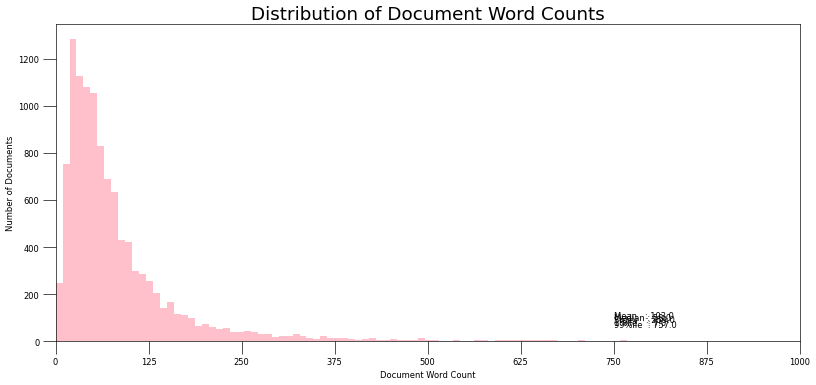

In [35]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=60)
plt.hist(doc_lens, bins = 1000, color='pink')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

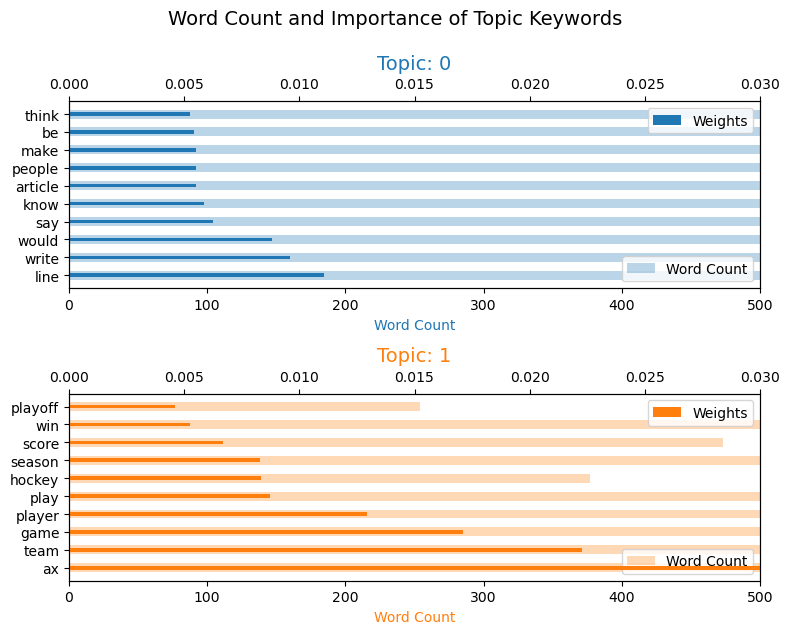

In [19]:
#plotting horizontal bar charts to show word count and importance for each topic

import matplotlib.pyplot as plot
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 

#Plot Word Count and Weights of Topic Keywords
fig, axes = plot.subplots(2,1,figsize=(8,6), dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    #data = df.loc[df.topic_id==i,:]
    #y = data['word']
    ax.barh(y='word', width= 'word_count',data = df.loc[df.topic_id==i,:], color=cols[i], height=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twiny()
    ax_twin.barh(y='word', width= 'importance',data = df.loc[df.topic_id==i,:],color=cols[i], height=0.2, label='Weights')
    ax.set_xlabel('Word Count', color=cols[i])
    ax_twin.set_xlim(0, 0.030); ax.set_xlim(0, 500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=14)
    ax.tick_params(axis='x', left=False)
    #ax.set_yticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='lower right'); ax_twin.legend(loc='upper right')
#     ax.legend(bbox_to_anchor=(0.5, 1.0))
#     ax_twin.legend(bbox_to_anchor=(0.25, 1.0))
    

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=14, y=1.05)    
plot.show()

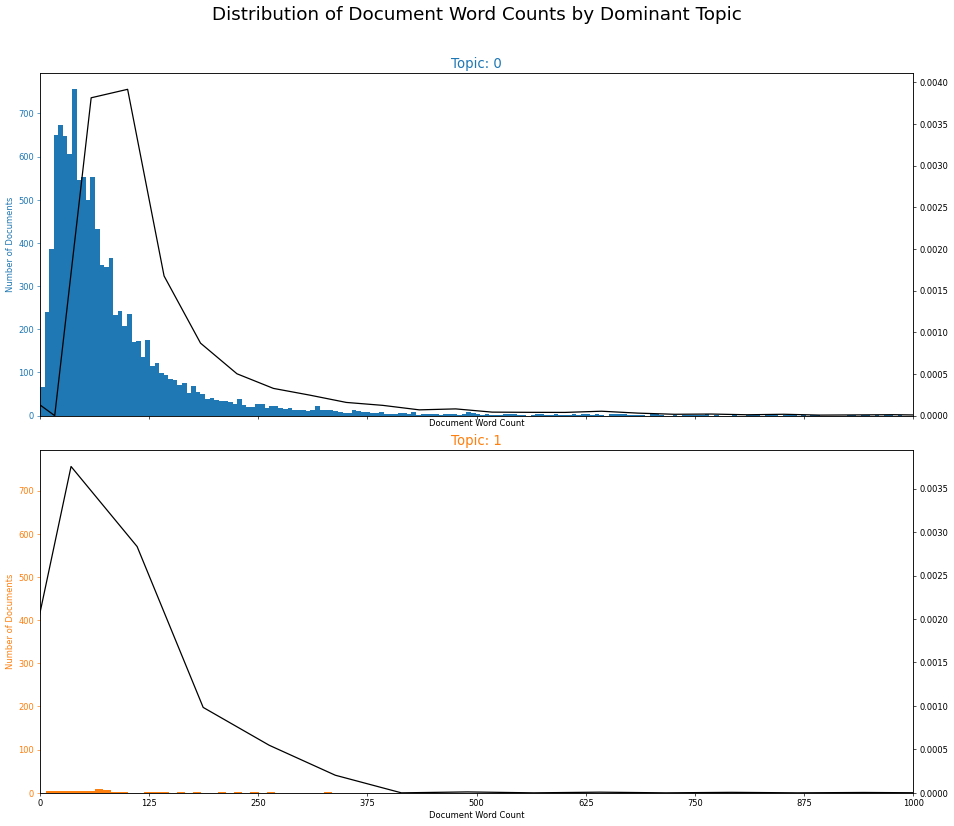

In [37]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,figsize=(16,14), dpi=60, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

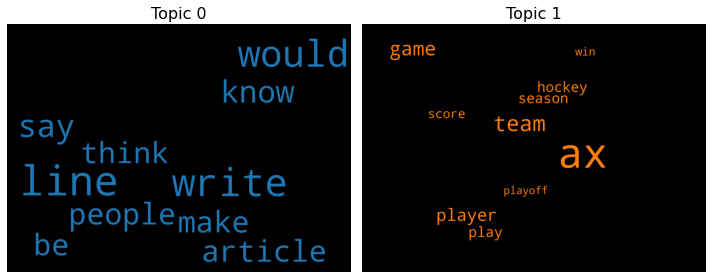

In [39]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1,2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

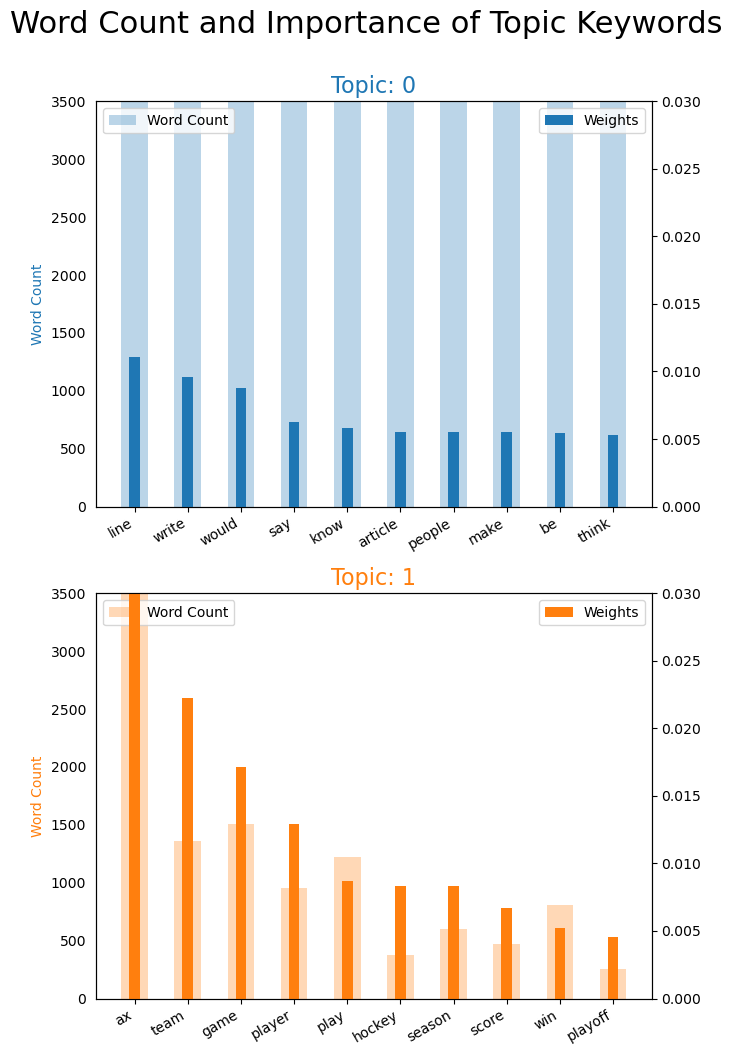

In [42]:
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2,1, figsize=(7,10), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12


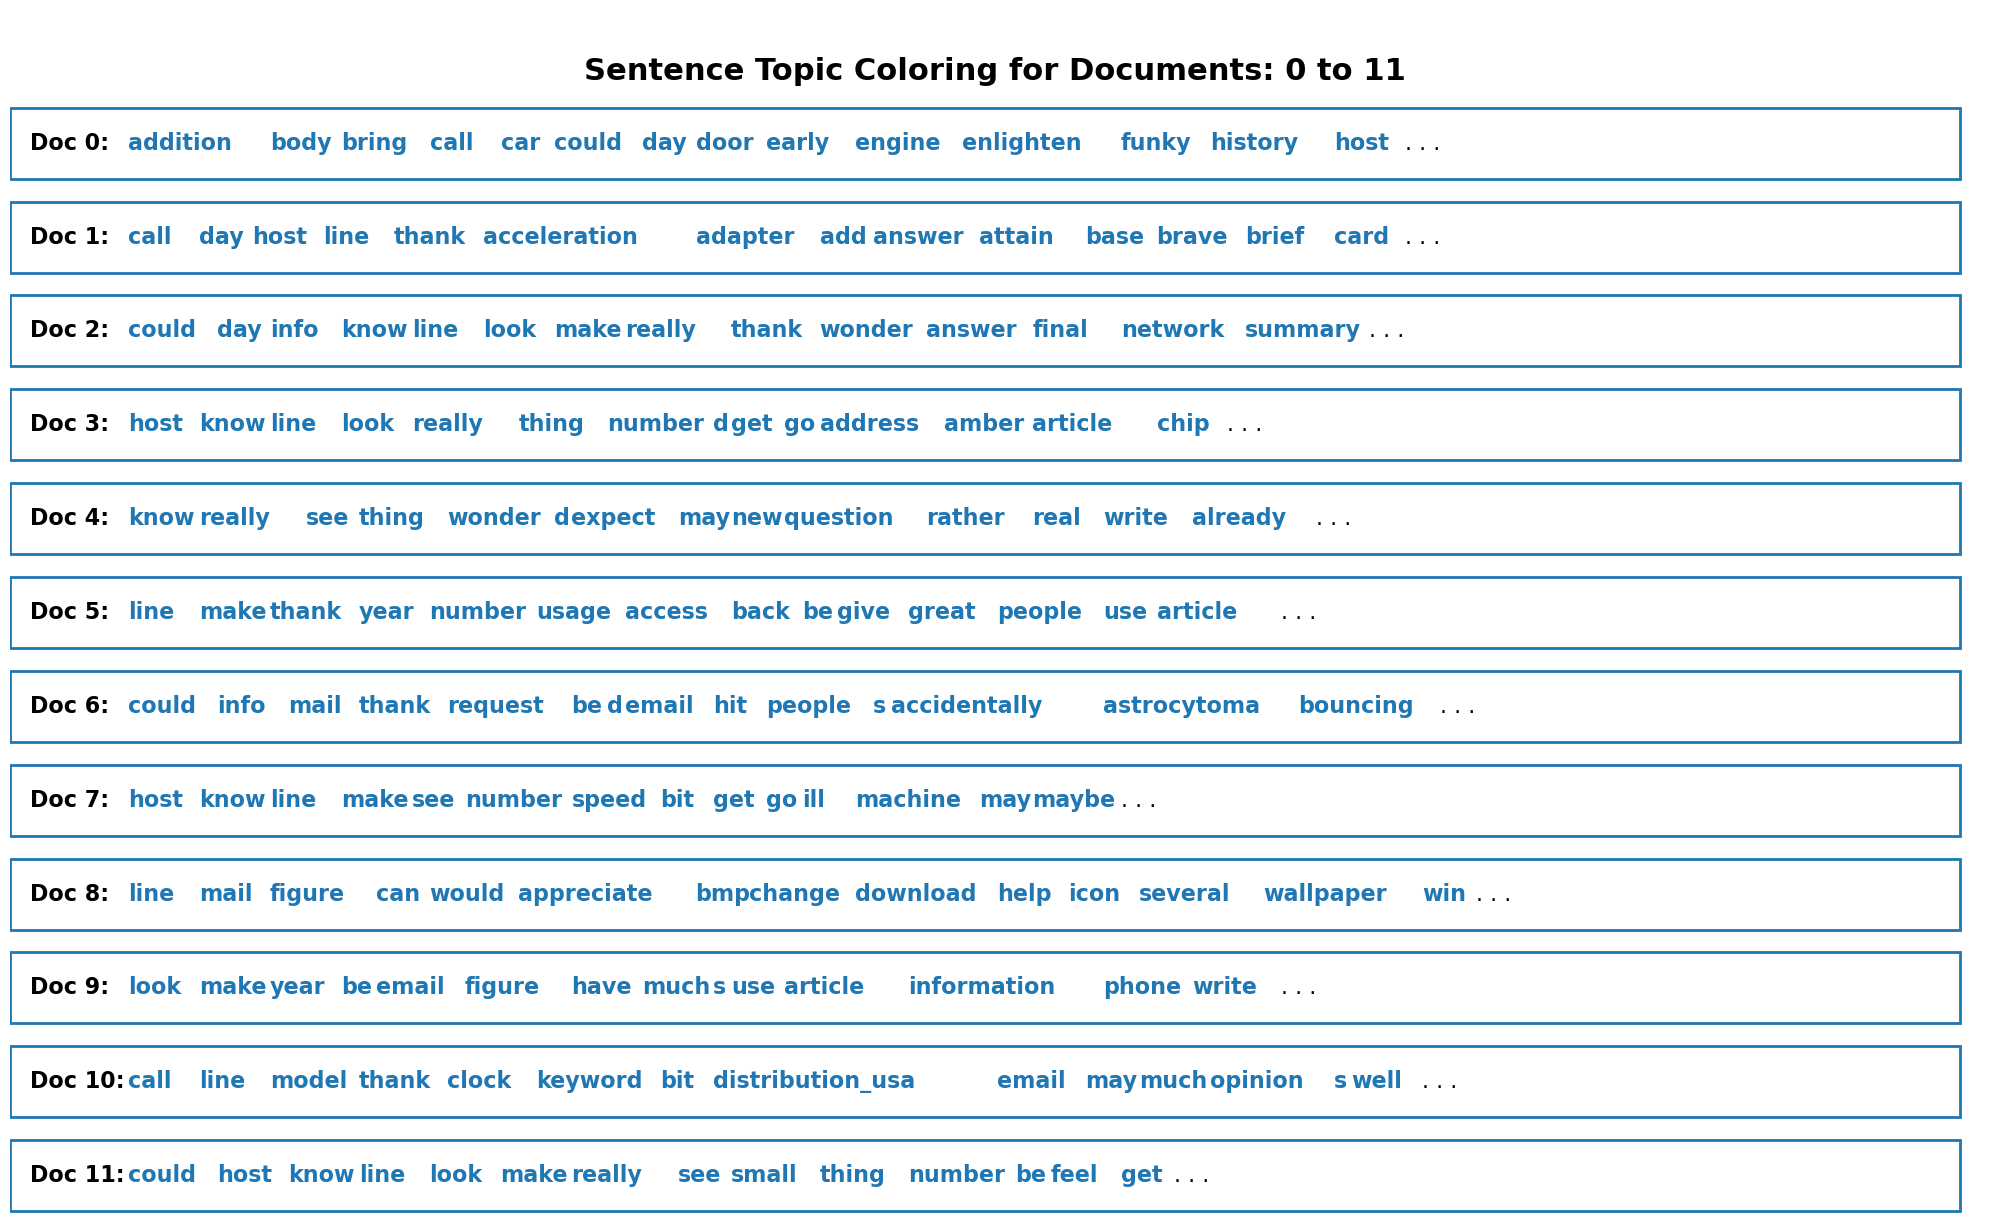

In [44]:
from matplotlib.patches import Rectangle

# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=100)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        print(i)
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 